# Import Libraries

In [1]:
#Disable all warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os  # Provides functions for interacting with the operating system
import pandas as pd  # Offers data structures and data analysis tools for Python
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices
import re  # Supplies regular expression matching operations
from collections import Counter  # Implements a counter for counting hashable objects
from nltk.tokenize import word_tokenize  # Tokenizes text into words
from nltk.corpus import stopwords  # Contains a list of common stop words in various languages
from gensim.models import Word2Vec  # Implements the Word2Vec algorithm for word embeddings
from arabert.preprocess import ArabertPreprocessor  # Preprocesses Arabic text for NLP tasks
from gensim.models import KeyedVectors  # Loads and works with pre-trained word vectors
import matplotlib.pyplot as plt  # Provides a MATLAB-like plotting framework
from sklearn.model_selection import train_test_split  # Splits arrays or matrices into random train and test subsets
from sklearn.feature_extraction.text import CountVectorizer  # Converts a collection of text documents to a matrix of token counts
from sklearn.metrics.pairwise import cosine_similarity  # Computes the cosine similarity between samples
from sklearn.manifold import TSNE  # Provides tools for dimensionality reduction
from transformers import AutoTokenizer, AutoModel  # Offers pre-trained models and tokenizers for NLP tasks
import torch  # Provides an optimized tensor library for deep learning
from sklearn.preprocessing import LabelEncoder  # Encodes target labels with value between 0 and n_classes-1
from sklearn.neural_network import MLPClassifier  # Implements a multi-layer perceptron (MLP) algorithm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Provides metrics to evaluate classification performance
from sklearn.metrics import classification_report  # Generates a text report showing main classification metrics
from keras.models import Sequential  # Allows creating a sequential neural network model
from keras.layers import LSTM, Dense, Dropout  # Provides layers for LSTM networks, dense layers, and dropout regularization


# Load and Combine the Data:

1- Load the provided TSV files.

2- Combine positive and negative samples.

3- Split the training data into training and validation sets.

In [5]:
def read_dataset(data_dir, num_samples=2500):
    
    # Define directories for negative and positive data
    neg_dir = os.path.join(data_dir, 'neg')
    pos_dir = os.path.join(data_dir, 'pos')
    
    # Get filenames for negative and positive samples
    neg_files = os.listdir(neg_dir)[:num_samples//2]
    pos_files = os.listdir(pos_dir)[:num_samples//2]
    
    # Read data from files
    neg_data = [open(os.path.join(neg_dir, file), 'r', encoding='utf-8').read() for file in neg_files]
    pos_data = [open(os.path.join(pos_dir, file), 'r', encoding='utf-8').read() for file in pos_files]
    
    # Create DataFrames for negative and positive data
    df_neg = pd.DataFrame({'text': neg_data, 'sentiment': ['negative']*len(neg_data)})
    df_pos = pd.DataFrame({'text': pos_data, 'sentiment': ['positive']*len(pos_data)})
    
    # Concatenate and reset the index of DataFrames
    return pd.concat([df_neg, df_pos]).reset_index(drop=True)


# Step 2: Tokenize the Data

Step 2.1: Tokenization

In [6]:
def tokenize_text(text):
    return word_tokenize(text)

 Step 2.2: Remove of Punctuation, Diacritical Marks(التشكيل), Numbers, and Non-Arabic Words

In [7]:
def clean_tokens(tokens):
    arabic_tokens = [word for word in tokens if re.match(r'^[\u0600-\u06FF]+$', word)]
    cleaned_tokens = [re.sub(arabic_punctuation, '', word) for word in arabic_tokens]
    cleaned_tokens = [re.sub(arabic_diacritics, '', word) for word in cleaned_tokens]
    return cleaned_tokens

Step 2.3: Data representation using BoW

In [8]:
def represent_data_with_bow(data):
    # Initialize CountVectorizer with custom tokenizer and preprocessor that do nothing
    vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
    
    # Fit and transform the 'tokens' column of the input data to a sparse matrix
    X = vectorizer.fit_transform(data['tokens'])
    
    # Convert the sparse matrix to a dense DataFrame with token names as columns
    bow_representation = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Return the BoW DataFrame and the fitted vectorizer
    return bow_representation, vectorizer

Step 2.4: Data representation function using arabert

In [9]:
def represent_data_with_arabert(data, tokenizer, model):
    embeddings = []  # List to store sentence embeddings
    all_words = []  # List to store sentences

    for w_tokens in data['tokens']:
        sentence = ' '.join(w_tokens)  # Join tokens to form a sentence
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)  # Tokenize the sentence
        outputs = model(**inputs)  # Get model outputs
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()  # Compute mean embedding
        embeddings.append(embedding)  # Append embedding to list
        all_words.append(sentence)  # Append sentence to list
    
    return embeddings, all_words  # Return embeddings and sentences

Step 2.5: Print the most similar words using BoW

In [10]:
def print_similar_words_bow(word, bow_vectorizer, bow_representation):
    
    # Check if the word is in the BoW vocabulary
    if word not in bow_vectorizer.get_feature_names_out():
        print(f"'{word}' not found in the BoW vocabulary.")
        return
    
    # Get the index of the word in the vocabulary
    word_index = bow_vectorizer.vocabulary_[word]
    
    # Get the word's vector from the BoW representation
    word_vector = bow_representation.iloc[:, word_index].values.reshape(1, -1)
    
    # Calculate cosine similarities between the word vector and all other vectors
    similarities = cosine_similarity(word_vector, bow_representation.T)
    
    # Get indices of the top 5 most similar words (excluding the word itself)
    most_similar_indices = similarities.argsort()[0][-6:-1]
    
    # Get the most similar words using the indices
    most_similar_words = [bow_vectorizer.get_feature_names_out()[idx] for idx in most_similar_indices]
    
    # Print the most similar words
    print(f"Most similar words to '{word}' using BoW:")
    for w in most_similar_words:
        print(w)

Step 2.6: Print the most similar words using AraBERT

In [11]:
def print_similar_words(word, embeddings, all_words, tokenizer, model):
    try:
        # Tokenize the word and get its embedding
        inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        word_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        
        # Convert embeddings list to numpy array
        embeddings_array = np.array(embeddings)
        
        # Calculate cosine similarities between the word embedding and all embeddings
        similarities = cosine_similarity(word_embedding.reshape(1, -1), embeddings_array)
        
        # Get indices of the top 5 most similar words (excluding the word itself)
        most_similar_indices = similarities.argsort()[0][-6:-1]
        
        # Get the most similar words using the indices
        most_similar_words = [all_words[idx] for idx in most_similar_indices]
        
        # Print the most similar words
        print(f"Most similar words to '{word}':")
        for w in most_similar_words:
            print(w)
    except KeyError:
        # Handle the case where the word is not found in the vocabulary
        print(f"'{word}' not found in the vocabulary.")

Step 2.7: Plot and visualize the embedding and their similarities using BoW

In [12]:
def visualize_embeddings_bow(words, vectorizer):
    
    word_vectors = []
    
    # Iterate over each word
    for word in words:
        # Check if the word is in the BoW vocabulary
        if word in vectorizer.get_feature_names_out():
            # If found, transform the word to its vector representation and append to the list
            word_vectors.append(vectorizer.transform([word]).toarray().flatten())
    
    # Check if any word vectors were found
    if not word_vectors:
        print("No words found in the BoW vocabulary for visualization.")
        return

    # Convert the list of word vectors to a numpy array
    vectors = np.array(word_vectors)
    
    # Initialize t-SNE model with specific parameters
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)  # Further reduce perplexity
    
    # Fit and transform the word vectors using t-SNE
    new_values = tsne_model.fit_transform(vectors)

    # Extract x and y coordinates from the transformed values
    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        # Annotate each point with its corresponding word
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    # Show the plot
    plt.show()

Step 2.8: Plot and visualize the embedding and their similarities using AraBERT

In [13]:
def visualize_embeddings(words, embeddings, tokenizer, model):
    word_embeddings = []
    
    # Iterate over each word
    for word in words:
        # Tokenize the word and get its embedding
        inputs = tokenizer(word, return_tensors="pt")
        outputs = model(**inputs)
        word_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        word_embeddings.append(word_embedding)
    
    # Convert the list of word embeddings to a numpy array
    vectors = np.array(word_embeddings)
    
    # Initialize t-SNE model with specific parameters
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    
    # Fit and transform the word embeddings using t-SNE
    new_values = tsne_model.fit_transform(vectors)

    # Extract x and y coordinates from the transformed values
    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        # Annotate each point with its corresponding word
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    # Show the plot
    plt.show()

# Read the dataset

In [14]:
data_dir = r'C:\Users\DELL\Desktop\Specialist\DataSet\Sentiment Analysis\data\arabic_tweets'
data = read_dataset(data_dir, num_samples=5000)
data

,text,sentiment
0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,negative
1,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,negative
2,لو بيدي أرجع ساعتي وين أرجع؟ إليا صدفه؟ والله ...,negative
3,💥 حمدا لله .. القيادة كما هي والاعداد في تزايد...,negative
4,#الهلال_الاهلي مبروك للهلال هاردلك للطحالب 🐸 و...,negative
...,...,...
4995,أحب نفسك، أعشقها ودللها .. فتش عن السعادة ستجد...,positive
4996,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...,positive
4997,#وش_يقول_الليل يقول ارقدي وفكي المسلمين شرك 🌚 ...,positive
4998,اللهم انك ترى ما لا نرى وتعلم ما لا نعلم فاكفن...,positive


# Tokenization

In [144]:
import nltk
nltk.download('punkt', quiet=True)  # This line downloads the default tokenizer (English)

# Now, download the Arabic tokenization model
nltk.download('punkt', quiet=True, raise_on_error=True, halt_on_error=False, download_dir=r'~/nltk_data/tokenizers/punkt')

True

In [15]:
data['tokens'] = data['text'].apply(tokenize_text)
data

,text,sentiment,tokens
0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,negative,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ..."
1,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,negative,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, بس, ل..."
2,لو بيدي أرجع ساعتي وين أرجع؟ إليا صدفه؟ والله ...,negative,"[لو, بيدي, أرجع, ساعتي, وين, أرجع؟, إليا, صدفه..."
3,💥 حمدا لله .. القيادة كما هي والاعداد في تزايد...,negative,"[💥, حمدا, لله, .., القيادة, كما, هي, والاعداد,..."
4,#الهلال_الاهلي مبروك للهلال هاردلك للطحالب 🐸 و...,negative,"[#, الهلال_الاهلي, مبروك, للهلال, هاردلك, للطح..."
...,...,...,...
4995,أحب نفسك، أعشقها ودللها .. فتش عن السعادة ستجد...,positive,"[أحب, نفسك،, أعشقها, ودللها, .., فتش, عن, السع..."
4996,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...,positive,"[بمناسبة, فوز, الهلال, .., 💙, سحب, على, آيفون,..."
4997,#وش_يقول_الليل يقول ارقدي وفكي المسلمين شرك 🌚 ...,positive,"[#, وش_يقول_الليل, يقول, ارقدي, وفكي, المسلمين..."
4998,اللهم انك ترى ما لا نرى وتعلم ما لا نعلم فاكفن...,positive,"[اللهم, انك, ترى, ما, لا, نرى, وتعلم, ما, لا, ..."


# Cleaning

Arabic punctuation marks and diacritical marks

In [16]:
arabic_punctuation = r'[\u060C\u061B\u061F\u066A\u066B\u066C\u066D\u06D4\u06DD\u06DE\u06E9\u06EA\u06EB\u06EC\u06ED\uFD3E\uFD3F]'
arabic_diacritics = r'[\u0610-\u061A\u064B-\u065F\u06D6-\u06ED]'

Removal of Punctuation, Diacritical Marks, Numbers, and Non-Arabic Words

In [17]:
data['tokens'] = data['text'].apply(lambda x: clean_tokens(tokenize_text(x)))
data

,text,sentiment,tokens
0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,negative,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ..."
1,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,negative,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, بس, ل..."
2,لو بيدي أرجع ساعتي وين أرجع؟ إليا صدفه؟ والله ...,negative,"[لو, بيدي, أرجع, ساعتي, وين, أرجع, إليا, صدفه,..."
3,💥 حمدا لله .. القيادة كما هي والاعداد في تزايد...,negative,"[حمدا, لله, القيادة, كما, هي, والاعداد, في, تز..."
4,#الهلال_الاهلي مبروك للهلال هاردلك للطحالب 🐸 و...,negative,"[مبروك, للهلال, هاردلك, للطحالب, وطز, في, النصر]"
...,...,...,...
4995,أحب نفسك، أعشقها ودللها .. فتش عن السعادة ستجد...,positive,"[أحب, نفسك, أعشقها, ودللها, فتش, عن, السعادة, ..."
4996,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...,positive,"[بمناسبة, فوز, الهلال, سحب, على, آيفون, رتويت,..."
4997,#وش_يقول_الليل يقول ارقدي وفكي المسلمين شرك 🌚 ...,positive,"[يقول, ارقدي, وفكي, المسلمين, شرك, بس, انا, قل..."
4998,اللهم انك ترى ما لا نرى وتعلم ما لا نعلم فاكفن...,positive,"[اللهم, انك, ترى, ما, لا, نرى, وتعلم, ما, لا, ..."


# Data representation

Data representation using BoW

In [18]:
bow_representation, bow_vectorizer = represent_data_with_bow(data)
bow_representation

,,؏,؏ليك,ء,آااه,آبائنا,آبدآع,آبيه,آتخيل,آتكبر,...,گمان,ھادئ,ھھ,ۆ,ۆشلون,ۆلكن,ۈ,ۈالله,یبقی,یوم
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
bow_vectorizer

CountVectorizer(preprocessor=<function represent_data_with_bow.<locals>.<lambda> at 0x0000019794D4AC10>,
                tokenizer=<function represent_data_with_bow.<locals>.<lambda> at 0x0000019794D4AF70>)

Data representation using Arabert

In [20]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabert")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabert")

In [21]:
arabert_embeddings, arabert_words = represent_data_with_arabert(data, tokenizer, model)
# arabert_embeddings

In [22]:
# arabert_words

# Print the most similar words

BoW

In [23]:
words_to_check = ["امتحان", "الأهلي", "الاتحاد"]
for word in words_to_check:
    print_similar_words_bow(word, bow_vectorizer, bow_representation)

Most similar words to 'امتحان' using BoW:
لتقديركم
انم
تاى
وثب
ماكنسلو
Most similar words to 'الأهلي' using BoW:
طرد
لكرة
إذن
والتغافل
إنتظار
Most similar words to 'الاتحاد' using BoW:
مختلفا
مهدد
للدوري
بطلا
يتوج


AraBERT

In [24]:
words_to_check = ["امتحان", "الأهلي", "الاتحاد"]
for word in words_to_check:
    print_similar_words(word, arabert_embeddings, arabert_words, tokenizer, model)

Most similar words to 'امتحان':
شهور تستاهل الزرقاء
شهور تستاهل الزرقاء
ي حظك
صح نومي
للاسف دوام
Most similar words to 'الأهلي':
المطر مشالله
خسارة التعليم فيهم
صبااح النصر
الجو يكسل
طفو الكهرب
Most similar words to 'الاتحاد':
صبااح النصر
صباح الاتحاد
سماعاتي خربوا
تيشرت القائد
طفو الكهرب


# Plot and visualize the embedding and their similarities

BoW

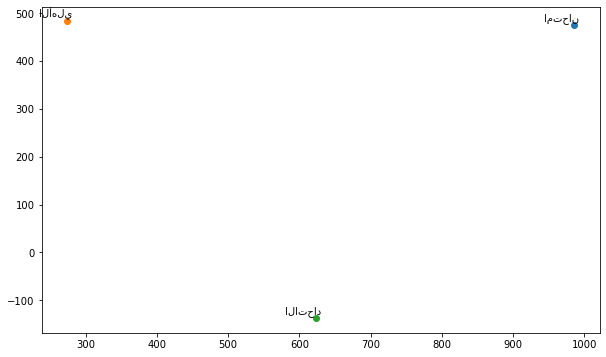

In [25]:
# Plot and visualize the embedding and their similarities using BoW
visualize_embeddings_bow(words_to_check, bow_vectorizer)

AraBERT

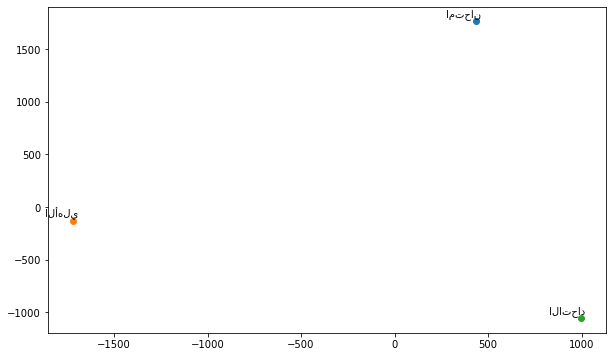

In [26]:
visualize_embeddings(words_to_check, arabert_embeddings, tokenizer, model)

In [27]:
# Splitting the data into training and testing sets for Bag-of-Words (BoW) representation
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_representation, data['sentiment'], test_size=0.2, random_state=42)

# Splitting the data into training and testing sets for AraBERT representation
X_train_arabert, X_test_arabert, y_train_arabert, y_test_arabert = train_test_split(
    arabert_embeddings, data['sentiment'], test_size=0.2, random_state=42)

# Label Encoding

In [28]:
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

In [29]:
# bow
# Fit and transform the class labels in your training set
y_train_encoded_bow = label_encoder.fit_transform(y_train_bow)
# Transform the class labels in your test set
y_test_encoded_bow = label_encoder.transform(y_test_bow)

# arabert
# Fit and transform the class labels in your training set
y_train_encoded_arabert = label_encoder.transform(y_train_arabert)
# Transform the class labels in your test set
y_test_encoded_arabert = label_encoder.transform(y_test_arabert)

# Build the Models

# BoW

Artificial Neural Network (ANN)

In [30]:
# Build an artificial neural network
ann_model_bow = MLPClassifier(hidden_layer_sizes=(4,), activation='relu', solver='adam', random_state=42)
ann_model_bow

MLPClassifier(hidden_layer_sizes=(4,), random_state=42)

LSTM Model

In [31]:
# Build an LSTM model
lstm_model_bow = Sequential([
    LSTM(64, input_shape=(1, X_train_bow.shape[1])),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# AraBERT 

Artificial Neural Network (ANN)

In [32]:
ann_model_arabert = MLPClassifier(hidden_layer_sizes=(4,), activation='relu', solver='adam', random_state=42)
ann_model_arabert

MLPClassifier(hidden_layer_sizes=(4,), random_state=42)

LSTM Model

In [33]:
# Assuming X_train_arabert is a list
X_train_arabert = np.array(X_train_arabert)  # Convert to NumPy array

# Now you can access its shape attribute
print(X_train_arabert.shape)

(4000, 768)


In [34]:
# Reshape input data for LSTM model
X_train_arabert_reshaped = np.expand_dims(X_train_arabert, axis=1)

In [35]:
# Define the LSTM model for AraBERT representation
lstm_model_arabert = Sequential([
    LSTM(64, input_shape=(1, X_train_arabert_reshaped.shape[2])),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [36]:
# Compile the LSTM model
lstm_model_arabert.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training

BoW Representation

Artificial Neural Network (ANN)

In [37]:
ann_model_bow.fit(X_train_bow, y_train_encoded_bow)

MLPClassifier(hidden_layer_sizes=(4,), random_state=42)

LSTM

In [38]:
lstm_model_bow.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Reshape input data for LSTM model
X_train_bow_reshaped = np.expand_dims(X_train_bow, axis=1)

In [40]:
lstm_model_bow.fit(X_train_bow_reshaped, y_train_encoded_bow)

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6006 - loss: 0.6739


AraBERT Representation

Artificial Neural Network (ANN)

In [41]:
ann_model_arabert.fit(X_train_arabert, y_train_encoded_arabert)

MLPClassifier(hidden_layer_sizes=(4,), random_state=42)

LSTM

In [42]:
lstm_model_arabert.fit(X_train_arabert_reshaped, y_train_encoded_arabert, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5628 - loss: 0.6801 - val_accuracy: 0.6538 - val_loss: 0.6405
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6489 - loss: 0.6273 - val_accuracy: 0.6350 - val_loss: 0.6535
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6578 - loss: 0.6193 - val_accuracy: 0.6425 - val_loss: 0.6260
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6825 - loss: 0.6016 - val_accuracy: 0.6800 - val_loss: 0.6129
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6895 - loss: 0.5954 - val_accuracy: 0.6587 - val_loss: 0.6254
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7035 - loss: 0.5656 - val_accuracy: 0.6600 - val_loss: 0.6203
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6929 - loss: 0.5682 - val_accuracy: 0.6662 - val_loss: 0.6133
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7321 - loss: 0.5420 - val

Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9460 - loss: 0.1426 - val_accuracy: 0.7138 - val_loss: 0.9290
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9551 - loss: 0.1212 - val_accuracy: 0.6862 - val_loss: 0.9919
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9491 - loss: 0.1328 - val_accuracy: 0.7013 - val_loss: 0.9805
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9662 - loss: 0.1021 - val_accuracy: 0.7038 - val_loss: 0.9738
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9659 - loss: 0.1061 - val_accuracy: 0.7063 - val_loss: 0.9407
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9611 - loss: 0.1070 - val_accuracy: 0.6988 - val_loss: 0.9636
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9598 - loss: 0.1121 - val_accuracy: 0.7125 - val_loss: 0.9727
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9704 - loss: 0.08

Evaluating

Bag-of-Words (BoW) Representation

Artificial Neural Network (ANN)

In [43]:
y_pred_bow_ann = ann_model_bow.predict(X_test_bow)

In [44]:
accuracy_bow_ann = accuracy_score(y_test_encoded_bow, y_pred_bow_ann)
precision_bow_ann = precision_score(y_test_encoded_bow, y_pred_bow_ann)
recall_bow_ann = recall_score(y_test_encoded_bow, y_pred_bow_ann)
f1_bow_ann = f1_score(y_test_encoded_bow, y_pred_bow_ann)

print("Bag-of-Words (BoW) Representation:")
print("Accuracy:", accuracy_bow_ann)
print("Precision:", precision_bow_ann)
print("Recall:", recall_bow_ann)
print("F1-score:", f1_bow_ann)

Bag-of-Words (BoW) Representation:
Accuracy: 0.691
Precision: 0.70020964360587
Recall: 0.668
F1-score: 0.6837256908904811


In [45]:
# Generate classification report for BoW representation
classification_report_bow_ann = classification_report(y_test_encoded_bow, y_pred_bow_ann)
print("Classification Report for Bag-of-Words (BoW) Representation:\n", classification_report_bow_ann)

Classification Report for Bag-of-Words (BoW) Representation:
               precision    recall  f1-score   support

           0       0.68      0.71      0.70       500
           1       0.70      0.67      0.68       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



LSTM model Evaluation

In [46]:
# Reshape input data for LSTM model
X_test_bow_reshaped = np.expand_dims(X_test_bow, axis=1)

In [47]:
y_pred_bow_lstm = lstm_model_bow.predict(X_test_bow_reshaped).argmax(axis=-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [48]:
y_test_encoded_bow.shape

(1000,)

In [49]:
y_pred_bow_lstm.shape

(1000,)

In [50]:
accuracy_bow_lstm = accuracy_score(y_test_encoded_bow, y_pred_bow_lstm)
precision_bow_lstm = precision_score(y_test_encoded_bow, y_pred_bow_lstm)
recall_bow_lstm = recall_score(y_test_encoded_bow, y_pred_bow_lstm)
f1_bow_lstm = f1_score(y_test_encoded_bow, y_pred_bow_lstm)

print("Bag-of-Words (BoW) Representation:")
print("Accuracy:", accuracy_bow_lstm)
print("Precision:", precision_bow_lstm)
print("Recall:", recall_bow_lstm)
print("F1-score:", f1_bow_lstm)

Bag-of-Words (BoW) Representation:
Accuracy: 0.688
Precision: 0.7259615384615384
Recall: 0.604
F1-score: 0.6593886462882096


In [51]:
# Generate classification report for BoW representation
classification_report_bow_lstm = classification_report(y_test_encoded_bow, y_pred_bow_lstm)
print("Classification Report for Bag-of-Words (BoW) Representation:\n", classification_report_bow_lstm)

Classification Report for Bag-of-Words (BoW) Representation:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71       500
           1       0.73      0.60      0.66       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



AraBERT Representation

Artificial Neural Network (ANN)

In [52]:
y_pred_arabert_ann = ann_model_arabert.predict(X_test_arabert)

In [53]:
accuracy_arabert_ann = accuracy_score(y_test_encoded_arabert, y_pred_arabert_ann)
precision_arabert_ann = precision_score(y_test_encoded_arabert, y_pred_arabert_ann)
recall_arabert_ann = recall_score(y_test_encoded_arabert, y_pred_arabert_ann)
f1_arabert_ann = f1_score(y_test_encoded_arabert, y_pred_arabert_ann)

print("AraBERT Representation:")
print("Accuracy:", accuracy_arabert_ann)
print("Precision:", precision_arabert_ann)
print("Recall:", recall_arabert_ann)
print("F1-score:", f1_arabert_ann)

AraBERT Representation:
Accuracy: 0.689
Precision: 0.702355460385439
Recall: 0.656
F1-score: 0.6783867631851085


In [54]:
# Generate classification report for AraBERT representation
classification_report_arabert_ann = classification_report(y_test_encoded_arabert, y_pred_arabert_ann)
print("Classification Report for AraBERT Representation:\n", classification_report_arabert_ann)

Classification Report for AraBERT Representation:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70       500
           1       0.70      0.66      0.68       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



LSTM Model

In [55]:
# Assuming X_train_arabert is a list
X_test_arabert = np.array(X_test_arabert)  # Convert to NumPy array

# Now you can access its shape attribute
print(X_train_arabert.shape)

(4000, 768)


In [56]:
# Reshape input data for LSTM model
X_test_arabert_reshaped = np.expand_dims(X_test_arabert, axis=1)

In [57]:
y_pred_arabert_lstm = lstm_model_arabert.predict(X_test_arabert_reshaped).argmax(axis=-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [58]:
accuracy_arabert_lstm = accuracy_score(y_test_encoded_arabert, y_pred_arabert_lstm)
precision_arabert_lstm = precision_score(y_test_encoded_arabert, y_pred_arabert_lstm)
recall_arabert_lstm = recall_score(y_test_encoded_arabert, y_pred_arabert_lstm)
f1_arabert_lstm = f1_score(y_test_encoded_arabert, y_pred_arabert_lstm)

print("Arabert Representation:")
print("Accuracy:", accuracy_arabert_lstm)
print("Precision:", precision_arabert_lstm)
print("Recall:", recall_arabert_lstm)
print("F1-score:", f1_arabert_lstm)

Arabert Representation:
Accuracy: 0.689
Precision: 0.6901408450704225
Recall: 0.686
F1-score: 0.6880641925777332


In [59]:
# Generate classification report for arabert representation
classification_report_arabert_lstm = classification_report(y_test_encoded_arabert, y_pred_arabert_lstm)
print("Classification Report for Arabert Representation:\n", classification_report_arabert_lstm)

Classification Report for Arabert Representation:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       500
           1       0.69      0.69      0.69       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

